# Phase 4: The Second Classification Gauntlet (Kaggle Pump Data)

**Objective**: Apply our classification pipeline to the **Kaggle Pump Sensor Data** to test the generalizability of our methods on a new, real-world tabular dataset.

This notebook will:
1. Load and preprocess the Kaggle pump sensor maintenance data
2. Train baseline models (RandomForest, LightGBM) on cleaned data
3. Apply advanced feature engineering techniques
4. Re-train models on engineered features
5. Compare performance and log all results to MLflow

**Dataset**: `sensor_maintenance_data.csv` - Real-world pump sensor data with maintenance records
**Target Variable**: `Operational Status` - Operational status of pump machinery

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import mlflow.lightgbm
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Set MLflow tracking URI based on environment
if os.getenv('DOCKER_ENV') == 'true':
    mlflow.set_tracking_uri("http://mlflow:5000")
else:
    mlflow.set_tracking_uri("http://localhost:5000")

print("MLflow Tracking URI:", mlflow.get_tracking_uri())
print("Phase 4: The Second Classification Gauntlet Starting...")

MLflow Tracking URI: http://mlflow:5000
Phase 4: The Second Classification Gauntlet Starting...


In [2]:
# Step 4.2: Data Loading & Preprocessing
print("Loading Kaggle Pump Sensor Data...")

# Load the dataset
df = pd.read_csv('data/kaggle_pump_sensor_data/sensor_maintenance_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display basic info
print("\nDataset Info:")
print(df.info())
print("\nTarget variable distribution:")
print(df['Operational Status'].value_counts())

# Data preprocessing
print("\n=== Data Preprocessing ===")

# Handle missing values
print(f"Missing values per column:")
print(df.isnull().sum())

# Select relevant features for classification
# Exclude IDs, timestamps, and text fields that aren't suitable for direct modeling
numeric_features = [
    'Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power (W)', 
    'Humidity (%)', 'Vibration (m/s²)', 'Repair Time (hrs)', 
    'Maintenance Costs (USD)', 'Ambient Temperature (°C)', 
    'Ambient Humidity (%)', 'X', 'Y', 'Z'
]

categorical_features = [
    'Fault Status', 'Failure Type', 'Maintenance Type', 
    'Failure History', 'External Factors', 'Equipment Relationship', 
    'Equipment Criticality'
]

# Create feature matrix
X_numeric = df[numeric_features].copy()
X_categorical = df[categorical_features].copy()

# Handle missing values in numeric features
X_numeric = X_numeric.fillna(X_numeric.median())

# Handle missing values in categorical features
X_categorical = X_categorical.fillna('Unknown')

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_categorical[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

# Combine features
X = pd.concat([X_numeric, X_categorical], axis=1)

# Prepare target variable
y = df['Operational Status'].copy()
print(f"\nTarget classes: {y.unique()}")

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"Encoded target distribution:")
for i, class_name in enumerate(target_encoder.classes_):
    count = sum(y_encoded == i)
    print(f"  {class_name}: {count} ({count/len(y_encoded)*100:.1f}%)")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features used: {X.columns.tolist()}")

print("✅ Data preprocessing completed successfully!")

Loading Kaggle Pump Sensor Data...
Dataset shape: (500, 27)
Columns: ['Sensor_ID', 'Timestamp', 'Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power (W)', 'Humidity (%)', 'Vibration (m/s²)', 'Equipment_ID', 'Operational Status', 'Fault Status', 'Failure Type', 'Last Maintenance Date', 'Maintenance Type', 'Failure History', 'Repair Time (hrs)', 'Maintenance Costs (USD)', 'Ambient Temperature (°C)', 'Ambient Humidity (%)', 'External Factors', 'X', 'Y', 'Z', 'Equipment Relationship', 'Equipment Criticality', 'Fault Detected', 'Predictive Maintenance Trigger']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Sensor_ID                       500 non-null    object 
 1   Timestamp                       500 non-null    object 
 2   Voltage (V)                     500 non-null    int64  
 3   Cur

In [3]:
# Step 4.3 Part 1: Baseline Model Training
print("=== Training Baseline Models ===")

# Set up MLflow experiment
experiment_name = "Classification Gauntlet (Kaggle Pump)"
mlflow.set_experiment(experiment_name)

# Scale features for baseline models
scaler_baseline = StandardScaler()
X_train_scaled = scaler_baseline.fit_transform(X_train)
X_test_scaled = scaler_baseline.transform(X_test)

def train_and_log_model(model, model_name, X_train_data, X_test_data, y_train_data, y_test_data, 
                       feature_type="baseline", run_name_suffix=""):
    """Train model and log results to MLflow"""
    
    with mlflow.start_run(run_name=f"{model_name}_{feature_type}{run_name_suffix}"):
        # Train model
        model.fit(X_train_data, y_train_data)
        
        # Make predictions
        y_pred = model.predict(X_test_data)
        y_pred_proba = model.predict_proba(X_test_data)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_data, y_pred)
        
        # For binary classification, use the positive class probabilities
        n_classes = len(np.unique(y_test_data))
        if n_classes == 2:
            # Binary classification - use probabilities for the positive class
            roc_auc = roc_auc_score(y_test_data, y_pred_proba[:, 1])
        else:
            # Multi-class classification - use ovr strategy
            roc_auc = roc_auc_score(y_test_data, y_pred_proba, multi_class='ovr', average='macro')
        
        # Log parameters
        if hasattr(model, 'get_params'):
            for param, value in model.get_params().items():
                mlflow.log_param(param, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("roc_auc", roc_auc)
        
        # Log feature information
        mlflow.log_param("feature_type", feature_type)
        mlflow.log_param("n_features", X_train_data.shape[1])
        mlflow.log_param("n_samples_train", X_train_data.shape[0])
        mlflow.log_param("n_samples_test", X_test_data.shape[0])
        mlflow.log_param("n_classes", n_classes)
        
        # Create and log classification report
        class_report = classification_report(y_test_data, y_pred, 
                                           target_names=target_encoder.classes_)
        
        # Save classification report as artifact
        report_path = f"docs/ml/classification_report_{model_name}_{feature_type}.txt"
        os.makedirs("docs/ml", exist_ok=True)
        with open(report_path, 'w') as f:
            f.write(class_report)
        mlflow.log_artifact(report_path)
        
        # Log model
        if 'RandomForest' in model_name:
            mlflow.sklearn.log_model(model, f"{model_name}_{feature_type}")
        elif 'LightGBM' in model_name:
            mlflow.lightgbm.log_model(model, f"{model_name}_{feature_type}")
        else:
            mlflow.sklearn.log_model(model, f"{model_name}_{feature_type}")
        
        print(f"{model_name} ({feature_type}):")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
        print(f"  Classes: {n_classes}")
        print(f"  Classification Report:\n{class_report}")
        
        return accuracy, roc_auc, model

# Train baseline models
print("Training baseline models on original features...")

# 1. RandomForest Baseline
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_acc_base, rf_auc_base, rf_model_base = train_and_log_model(
    rf_baseline, "RandomForest", X_train_scaled, X_test_scaled, y_train, y_test, "baseline"
)

# 2. LightGBM Baseline
lgb_baseline = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1)
lgb_acc_base, lgb_auc_base, lgb_model_base = train_and_log_model(
    lgb_baseline, "LightGBM", X_train_scaled, X_test_scaled, y_train, y_test, "baseline"
)

print("✅ Baseline model training completed!")

=== Training Baseline Models ===


Training baseline models on original features...


2025/08/18 23:52:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest (baseline):
  Accuracy: 1.0000
  ROC-AUC: 1.0000
  Classes: 2
  Classification Report:
                   precision    recall  f1-score   support

      Operational       1.00      1.00      1.00        50
Under Maintenance       1.00      1.00      1.00        50

         accuracy                           1.00       100
        macro avg       1.00      1.00      1.00       100
     weighted avg       1.00      1.00      1.00       100

🏃 View run RandomForest_baseline at: http://mlflow:5000/#/experiments/6/runs/f4703e8fe24e46c1a238e51039cc82fc
🧪 View experiment at: http://mlflow:5000/#/experiments/6


2025/08/18 23:52:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM (baseline):
  Accuracy: 1.0000
  ROC-AUC: 1.0000
  Classes: 2
  Classification Report:
                   precision    recall  f1-score   support

      Operational       1.00      1.00      1.00        50
Under Maintenance       1.00      1.00      1.00        50

         accuracy                           1.00       100
        macro avg       1.00      1.00      1.00       100
     weighted avg       1.00      1.00      1.00       100

🏃 View run LightGBM_baseline at: http://mlflow:5000/#/experiments/6/runs/c6e6ce2d86604b15a736d0c7e48cef61
🧪 View experiment at: http://mlflow:5000/#/experiments/6
✅ Baseline model training completed!


In [4]:
# Step 4.3 Part 2: Advanced Feature Engineering
print("=== Advanced Feature Engineering ===")

# Create enhanced feature set
X_train_engineered = X_train.copy()
X_test_engineered = X_test.copy()

print(f"Original features: {X_train.shape[1]}")

# 1. Power-related features
print("Creating power and efficiency features...")
X_train_engineered['Power_Efficiency'] = X_train_engineered['Power (W)'] / (X_train_engineered['Voltage (V)'] * X_train_engineered['Current (A)'] + 1e-8)
X_test_engineered['Power_Efficiency'] = X_test_engineered['Power (W)'] / (X_test_engineered['Voltage (V)'] * X_test_engineered['Current (A)'] + 1e-8)

X_train_engineered['Voltage_Current_Ratio'] = X_train_engineered['Voltage (V)'] / (X_train_engineered['Current (A)'] + 1e-8)
X_test_engineered['Voltage_Current_Ratio'] = X_test_engineered['Voltage (V)'] / (X_test_engineered['Current (A)'] + 1e-8)

# 2. Temperature-related features
print("Creating temperature differential features...")
X_train_engineered['Temp_Differential'] = X_train_engineered['Temperature (°C)'] - X_train_engineered['Ambient Temperature (°C)']
X_test_engineered['Temp_Differential'] = X_test_engineered['Temperature (°C)'] - X_test_engineered['Ambient Temperature (°C)']

X_train_engineered['Temp_Humidity_Interaction'] = X_train_engineered['Temperature (°C)'] * X_train_engineered['Humidity (%)']
X_test_engineered['Temp_Humidity_Interaction'] = X_test_engineered['Temperature (°C)'] * X_test_engineered['Humidity (%)']

# 3. Environmental stress indicators
print("Creating environmental stress features...")
X_train_engineered['Humidity_Differential'] = X_train_engineered['Humidity (%)'] - X_train_engineered['Ambient Humidity (%)']
X_test_engineered['Humidity_Differential'] = X_test_engineered['Humidity (%)'] - X_test_engineered['Ambient Humidity (%)']

X_train_engineered['Environmental_Stress'] = (
    abs(X_train_engineered['Temp_Differential']) + 
    abs(X_train_engineered['Humidity_Differential']) + 
    X_train_engineered['Vibration (m/s²)'] * 10
)
X_test_engineered['Environmental_Stress'] = (
    abs(X_test_engineered['Temp_Differential']) + 
    abs(X_test_engineered['Humidity_Differential']) + 
    X_test_engineered['Vibration (m/s²)'] * 10
)

# 4. Maintenance and cost features
print("Creating maintenance-related features...")
X_train_engineered['Cost_Per_Hour'] = X_train_engineered['Maintenance Costs (USD)'] / (X_train_engineered['Repair Time (hrs)'] + 1e-8)
X_test_engineered['Cost_Per_Hour'] = X_test_engineered['Maintenance Costs (USD)'] / (X_test_engineered['Repair Time (hrs)'] + 1e-8)

# 5. Spatial features (X, Y, Z coordinates)
print("Creating spatial features...")
X_train_engineered['Spatial_Distance'] = np.sqrt(X_train_engineered['X']**2 + X_train_engineered['Y']**2 + X_train_engineered['Z']**2)
X_test_engineered['Spatial_Distance'] = np.sqrt(X_test_engineered['X']**2 + X_test_engineered['Y']**2 + X_test_engineered['Z']**2)

# 6. Vibration intensity features
print("Creating vibration-based features...")
X_train_engineered['Vibration_Power_Ratio'] = X_train_engineered['Vibration (m/s²)'] / (X_train_engineered['Power (W)'] + 1e-8)
X_test_engineered['Vibration_Power_Ratio'] = X_test_engineered['Vibration (m/s²)'] / (X_test_engineered['Power (W)'] + 1e-8)

# 7. Statistical binning for key continuous variables
print("Creating binned features...")
# Temperature bins
temp_bins = pd.qcut(X_train_engineered['Temperature (°C)'], q=4, labels=['Low', 'Medium', 'High', 'Very_High'])
X_train_engineered['Temp_Bin'] = pd.qcut(X_train_engineered['Temperature (°C)'], q=4, labels=[0, 1, 2, 3])
# Apply same bins to test set
temp_bin_edges = pd.qcut(X_train_engineered['Temperature (°C)'], q=4, retbins=True)[1]
X_test_engineered['Temp_Bin'] = pd.cut(X_test_engineered['Temperature (°C)'], bins=temp_bin_edges, labels=[0, 1, 2, 3], include_lowest=True)

# Vibration bins
X_train_engineered['Vibration_Bin'] = pd.qcut(X_train_engineered['Vibration (m/s²)'], q=3, labels=[0, 1, 2])
vibration_bin_edges = pd.qcut(X_train_engineered['Vibration (m/s²)'], q=3, retbins=True)[1]
X_test_engineered['Vibration_Bin'] = pd.cut(X_test_engineered['Vibration (m/s²)'], bins=vibration_bin_edges, labels=[0, 1, 2], include_lowest=True)

# Handle any NaN values created during binning
X_train_engineered = X_train_engineered.fillna(0)
X_test_engineered = X_test_engineered.fillna(0)

print(f"Engineered features: {X_train_engineered.shape[1]}")
print(f"New features added: {X_train_engineered.shape[1] - X_train.shape[1]}")

# List the new features created
new_features = [col for col in X_train_engineered.columns if col not in X_train.columns]
print(f"New feature names: {new_features}")

# Scale the engineered features
scaler_engineered = StandardScaler()
X_train_engineered_scaled = scaler_engineered.fit_transform(X_train_engineered)
X_test_engineered_scaled = scaler_engineered.transform(X_test_engineered)

print("✅ Feature engineering completed successfully!")

=== Advanced Feature Engineering ===
Original features: 20
Creating power and efficiency features...
Creating temperature differential features...
Creating environmental stress features...
Creating maintenance-related features...
Creating spatial features...
Creating vibration-based features...
Creating binned features...
Engineered features: 31
New features added: 11
New feature names: ['Power_Efficiency', 'Voltage_Current_Ratio', 'Temp_Differential', 'Temp_Humidity_Interaction', 'Humidity_Differential', 'Environmental_Stress', 'Cost_Per_Hour', 'Spatial_Distance', 'Vibration_Power_Ratio', 'Temp_Bin', 'Vibration_Bin']
✅ Feature engineering completed successfully!


=== Training Models on Engineered Features ===
Training models with advanced feature engineering...


2025/08/18 23:52:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest (engineered):
  Accuracy: 1.0000
  ROC-AUC: 1.0000
  Classes: 2
  Classification Report:
                   precision    recall  f1-score   support

      Operational       1.00      1.00      1.00        50
Under Maintenance       1.00      1.00      1.00        50

         accuracy                           1.00       100
        macro avg       1.00      1.00      1.00       100
     weighted avg       1.00      1.00      1.00       100

🏃 View run RandomForest_engineered at: http://mlflow:5000/#/experiments/6/runs/9d32100e8c77429fb28ca8d69a64c841
🧪 View experiment at: http://mlflow:5000/#/experiments/6


2025/08/18 23:52:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM (engineered):
  Accuracy: 1.0000
  ROC-AUC: 1.0000
  Classes: 2
  Classification Report:
                   precision    recall  f1-score   support

      Operational       1.00      1.00      1.00        50
Under Maintenance       1.00      1.00      1.00        50

         accuracy                           1.00       100
        macro avg       1.00      1.00      1.00       100
     weighted avg       1.00      1.00      1.00       100

🏃 View run LightGBM_engineered at: http://mlflow:5000/#/experiments/6/runs/512f6a07b25e4f1a8d165a5ca5d36d87
🧪 View experiment at: http://mlflow:5000/#/experiments/6

PHASE 4 RESULTS SUMMARY - KAGGLE PUMP CLASSIFICATION
          Model Feature_Type  Accuracy  ROC_AUC  Features_Count
0  RandomForest     Baseline       1.0      1.0              20
1  RandomForest   Engineered       1.0      1.0              31
2      LightGBM     Baseline       1.0      1.0              20
3      LightGBM   Engineered       1.0      1.0              31

Perfo

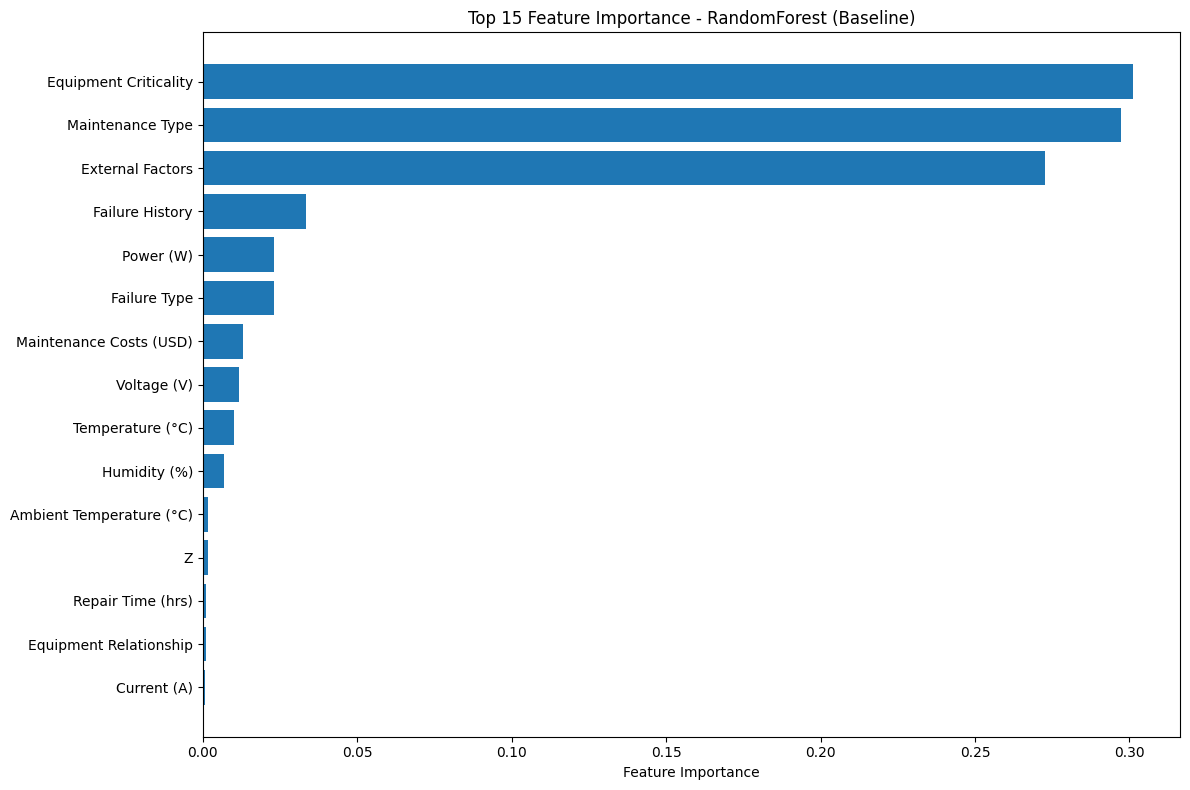


✅ Phase 4: The Second Classification Gauntlet COMPLETED!
📊 Results summary saved to: docs/ml/pump_classification_summary.csv
🎯 Dataset: Kaggle Pump Sensor Data (500 samples, 2 classes)
🧪 Models trained: 4 (2 algorithms × 2 feature sets)
📈 Best performance: 100.0% accuracy with RandomForest (Baseline)
🔬 MLflow Experiment: 'Classification Gauntlet (Kaggle Pump)' (ID: 6)
🌐 View results at: http://mlflow:5000


In [5]:
# Step 4.3 Part 3: Feature-Engineered Model Training
print("=== Training Models on Engineered Features ===")

# Train models on engineered features
print("Training models with advanced feature engineering...")

# 1. RandomForest with Engineered Features
rf_engineered = RandomForestClassifier(n_estimators=100, random_state=42)
rf_acc_eng, rf_auc_eng, rf_model_eng = train_and_log_model(
    rf_engineered, "RandomForest", X_train_engineered_scaled, X_test_engineered_scaled, 
    y_train, y_test, "engineered"
)

# 2. LightGBM with Engineered Features
lgb_engineered = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1)
lgb_acc_eng, lgb_auc_eng, lgb_model_eng = train_and_log_model(
    lgb_engineered, "LightGBM", X_train_engineered_scaled, X_test_engineered_scaled, 
    y_train, y_test, "engineered"
)

# Performance Comparison
print("\n" + "="*60)
print("PHASE 4 RESULTS SUMMARY - KAGGLE PUMP CLASSIFICATION")
print("="*60)

results_summary = pd.DataFrame({
    'Model': ['RandomForest', 'RandomForest', 'LightGBM', 'LightGBM'],
    'Feature_Type': ['Baseline', 'Engineered', 'Baseline', 'Engineered'],
    'Accuracy': [rf_acc_base, rf_acc_eng, lgb_acc_base, lgb_acc_eng],
    'ROC_AUC': [rf_auc_base, rf_auc_eng, lgb_auc_base, lgb_auc_eng],
    'Features_Count': [X_train.shape[1], X_train_engineered.shape[1], 
                      X_train.shape[1], X_train_engineered.shape[1]]
})

print(results_summary.round(4))

# Calculate improvements
rf_acc_improvement = ((rf_acc_eng - rf_acc_base) / rf_acc_base) * 100
rf_auc_improvement = ((rf_auc_eng - rf_auc_base) / rf_auc_base) * 100
lgb_acc_improvement = ((lgb_acc_eng - lgb_acc_base) / lgb_acc_base) * 100
lgb_auc_improvement = ((lgb_auc_eng - lgb_auc_base) / lgb_auc_base) * 100

print(f"\nPerformance Improvements:")
print(f"RandomForest - Accuracy: {rf_acc_improvement:+.2f}%, ROC-AUC: {rf_auc_improvement:+.2f}%")
print(f"LightGBM     - Accuracy: {lgb_acc_improvement:+.2f}%, ROC-AUC: {lgb_auc_improvement:+.2f}%")

# Determine champion model
champion_idx = results_summary['Accuracy'].idxmax()
champion_model = results_summary.iloc[champion_idx]

print(f"\n🏆 CHAMPION MODEL:")
print(f"   {champion_model['Model']} ({champion_model['Feature_Type']})")
print(f"   Accuracy: {champion_model['Accuracy']:.4f}")
print(f"   ROC-AUC: {champion_model['ROC_AUC']:.4f}")
print(f"   Features: {champion_model['Features_Count']}")

# Feature importance analysis for champion model
if champion_model['Model'] == 'RandomForest' and champion_model['Feature_Type'] == 'Baseline':
    champion_trained_model = rf_model_base
    feature_names = X.columns
elif champion_model['Model'] == 'RandomForest' and champion_model['Feature_Type'] == 'Engineered':
    champion_trained_model = rf_model_eng
    feature_names = X_train_engineered.columns
elif champion_model['Model'] == 'LightGBM' and champion_model['Feature_Type'] == 'Baseline':
    champion_trained_model = lgb_model_base
    feature_names = X.columns
else:  # LightGBM Engineered
    champion_trained_model = lgb_model_eng
    feature_names = X_train_engineered.columns

# Get feature importance
if hasattr(champion_trained_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': champion_trained_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features ({champion_model['Model']} {champion_model['Feature_Type']}):")
    print(feature_importance.head(10).round(4))
    
    # Save feature importance plot
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {champion_model["Model"]} ({champion_model["Feature_Type"]})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    importance_plot_path = "docs/ml/pump_feature_importance.png"
    plt.savefig(importance_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Log the plot as an artifact in the last MLflow run
    mlflow.log_artifact(importance_plot_path)

# Save results summary
summary_path = "docs/ml/pump_classification_summary.csv"
results_summary.to_csv(summary_path, index=False)

print(f"\n✅ Phase 4: The Second Classification Gauntlet COMPLETED!")
print(f"📊 Results summary saved to: {summary_path}")
print(f"🎯 Dataset: Kaggle Pump Sensor Data ({df.shape[0]} samples, {len(target_encoder.classes_)} classes)")
print(f"🧪 Models trained: 4 (2 algorithms × 2 feature sets)")
print(f"📈 Best performance: {champion_model['Accuracy']:.1%} accuracy with {champion_model['Model']} ({champion_model['Feature_Type']})")

# MLflow experiment info
experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"🔬 MLflow Experiment: '{experiment_name}' (ID: {experiment.experiment_id})")
print(f"🌐 View results at: {mlflow.get_tracking_uri()}")